# The Rise of GitHub

GitHub has become the dominant channel that development teams use to collaborate on code. Wikipedia's [Timeline of GitHub](https://en.wikipedia.org/wiki/Timeline_of_GitHub) documents GitHub's rise to dominance as a *business*. We will use a `mirror` crawl to analyze GitHub's rise as a *platform*.

## Dataset

Any analysis must start with data. The dataset we use here are the results of a crawl of public GitHub repositories conducted using [`mirror`](https://github.com/simiotics/mirror).

You can build the same dataset by using `mirror github crawl` to build up the raw dataset of basic repository information and then `mirror github sync` to create a SQLite database of the type used in this notebook.

If you do create your own dataset, change the variable below to point at the SQLite database you generate.

In [172]:
from datetime import datetime
import json
import math
import os

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tqdm import tqdm

import requests

In [2]:
GITHUB_SQLITE = os.path.expanduser('~/data/mirror/github.sqlite')

Let us explore the structure dataset before we dive into our analysis.

Basic repository metadata (extracted by crawling the GitHub [`/repositories`](https://developer.github.com/v3/repos/#list-all-public-repositories) endpoint) is stored in the `repositories` table of this database. This is its schema:

In [3]:
import sqlite3

In [4]:
conn = sqlite3.connect(GITHUB_SQLITE)
c = conn.cursor()

In [5]:
r = c.execute('select sql from sqlite_master where name="repositories";')

In [6]:
repositories_schema = r.fetchone()[0]

In [7]:
print(repositories_schema)

CREATE TABLE repositories (
        github_id UNSIGNED BIG INT,
        full_name TEXT NOT NULL,
        owner TEXT NOT NULL,
        html_url TEXT NOT NULL,
        api_url TEXT NOT NULL,
        is_fork BOOLEAN
    )


These columns do not provide comprehensive repository information, but they already allow us to understand some interesting things.

To speed up these preliminary analyses, since `mirror` does not automatically create indices in the database, let us create some of our own:

### Number of public repositories on GitHub

In [8]:
r = c.execute('select count(*) from repositories;')
result = r.fetchone()
print(result[0])

128411417


### Proportion of repositories that are forks

In [51]:
results = c.execute('select is_fork from repositories;')
total = 0
forks = 0
for row in tqdm(results):
    total += 1
    forks += (row[0] == 1)

print('Proportion of repositories that are forks:', forks/total)

128411417it [01:26, 1484015.10it/s]

Proportion of repositories that are forks: 0.41683523358363067


### Number of users who have created public repositories

In [10]:
results = c.execute('select owner from repositories;')
owners = set([])
for row in tqdm(results):
    owners.add(row[0])

print('Number of users who have created public repositories:', len(owners))

128411417it [02:36, 822352.26it/s]

Number of users who have created public repositories: 23298697


In [11]:
# The owners set takes over a gigabyte of memory on only the first full crawl.
# Better to free this memory up.
del owners

## Rise

The basic repository metadata that GitHub's `/repositories` endpoint provides does not give any information about when a repository was created. We will rely on the [`/repos`](https://developer.github.com/v3/repos/#get) endpoint.

The `api_url` column of the Mirror crawl `repositories` table conveniently populates the endpoint URL with repository information, so we will use this column.

### Sampling

We have to make GitHub API calls to retrieve creation time information for repositories in our dataset. With over 120 million repositories in the dataset and with a rate limit of 5000 requests per hour (authenticated) to the GitHub API, it would take a long time to collect the creation time for every repository in our database. We will have to sample.

For sampling, we use the following parameters:
+ `NUM_SAMPLES` - Number of total repositories that should be sampled for creation time analysis
+ `GITHUB_TOKEN_FILE` - File containing the token for authentication against the GitHub API ([instructions](https://github.com/settings/tokens) to create an API token)

In [24]:
NUM_SAMPLES = 500
headers = {}
# Comment the following lines out if you do not want to make authenticated calls against the GitHub API
# If you do authenticate, make sure that the path below points at a file with your token.
GITHUB_TOKEN_FILE = os.path.expanduser('~/.secrets/github-mirror.txt')
with open(GITHUB_TOKEN_FILE, 'r') as ifp:
    GITHUB_TOKEN = ifp.read().strip()
    headers['Authorization'] = f'token {GITHUB_TOKEN}'

In [18]:
gap = int(total/NUM_SAMPLES)

In [22]:
results = c.execute('select github_id, api_url from repositories;')
sample = []
for i, row in tqdm(enumerate(results)):
    if i % gap == 0:
        sample.append((i, row[0], row[1]))

128411417it [02:01, 1056401.35it/s]


In [21]:
len(sample)

500

In [28]:
sample_metadata = []
for i, github_id, api_url in tqdm(sample):
    response = requests.get(api_url, headers=headers)
    entry = {
        'position': i,
        'github_id': github_id,
        'repository': response.json(),
    }
    sample_metadata.append(entry)

In [32]:
SAMPLE_METADATA_FILE = os.path.expanduser('~/data/mirror/rise-of-github-sample.jsonl')
with open(SAMPLE_METADATA_FILE, 'w') as ofp:
    for entry in sample_metadata:
        print(json.dumps(entry), file=ofp)

This file is available as a Gist. [Download here](https://gist.github.com/nkashy1/c4ca78c5d6c2c2da2b03b4a730f6e194).

### Analysis

The sample repository metadata is the subject of this analysis, with the goal of building a simple histogram to visualize the growth of GitHub as a platform.

Some of the repositories have bad metadata - either because the repository has been deleted or because access to repository metadata has been blocked. We define "bad" metadata by metadata that doesn't have a `created_at` key. Let us count how many such repositories there are:

In [49]:
num_bad = 0
for entry in tqdm(sample_metadata):
    try:
        entry.get('repository', {})['created_at']
    except KeyError:
        num_bad += 1

print(num_bad)

100%|██████████| 500/500 [00:00<00:00, 626951.27it/s]

19


That still gives us enough samples to build a meaningful histogram out of, if we first filter out the `valid_sample_metadata`:

In [50]:
valid_sample_metadata = [entry for entry in sample_metadata if entry.get('repository', {}).get('created_at') is not None]
len(valid_sample_metadata)

481

Conveniently, the results of the Mirror crawl are sorted. This allows us to count the number of repositories created between samples by simply taking a difference of the `position` keys in `sample_metadata`.

In [181]:
x = []
bins = []
weights = []
labels = []
for i, entry in tqdm(enumerate(valid_sample_metadata[:-1])):
    created_at = datetime.strptime(entry['repository']['created_at'], '%Y-%m-%dT%H:%M:%SZ')
    labels.append(created_at.strftime('%Y-%m-%d'))
    x.append(created_at.timestamp())
    bins.append(created_at.timestamp())
    weights.append(valid_sample_metadata[i+1]['github_id'] - entry['github_id'])

480it [00:00, 62896.87it/s]


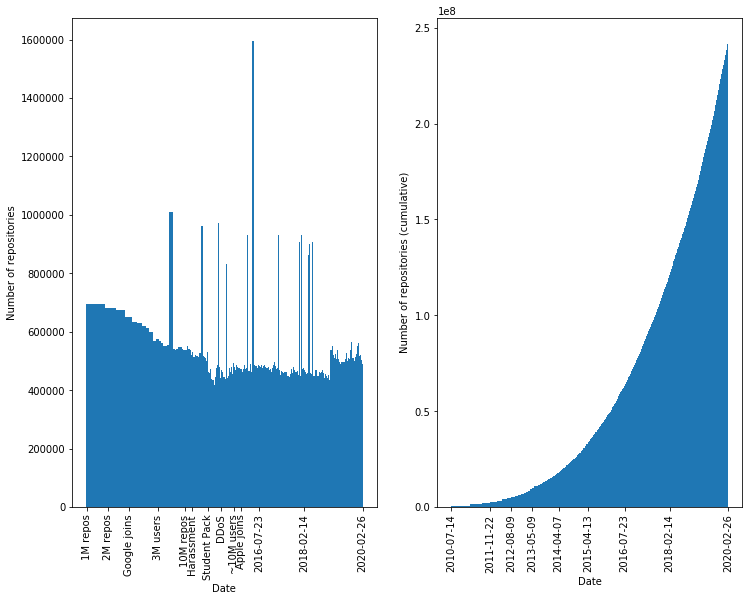

In [222]:
ticks = [bins[0]]
ticklabels = [labels[0]]
log = int(math.log(len(bins), 2))
for i in range(log-1, 0, -1):
    idx = int(len(bins)/(2**i))
    ticks.append(bins[idx])
    ticklabels.append(labels[idx])
ticks.append(bins[-1])
ticklabels.append(labels[-1])

timeline_ticks = [
    datetime(2010, 7, 24).timestamp(),
    datetime(2011, 4, 20).timestamp(),
    datetime(2012, 1, 17).timestamp(),
    datetime(2013, 1, 14).timestamp(),
    datetime(2013, 12, 23).timestamp(),
    datetime(2014, 3, 17).timestamp(),
    datetime(2014, 10, 7).timestamp(),
    datetime(2015, 3, 26).timestamp(),
    datetime(2015, 9, 1).timestamp(),
    datetime(2015, 12, 3).timestamp(),
] + ticks[-3:]
timeline_ticklabels = [
    '1M repos',
    '2M repos',
    'Google joins',
    '3M users',
    '10M repos',
    'Harassment',
    'Student Pack',
    'DDoS',
    '~10M users',
    'Apple joins',
] + ticklabels[-3:]

fig, ax = plt.subplots(1, 2, figsize=(12,9))
_ = ax[0].hist(x=x, bins=bins, weights=weights, cumulative=False)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of repositories')
ax[0].set_xticks(timeline_ticks)
ax[0].set_xticklabels(timeline_ticklabels, rotation='vertical')

_ = ax[1].hist(x=x, bins=bins, weights=weights, cumulative=True)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of repositories (cumulative)')
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(ticklabels, rotation='vertical')

plt.show()
fig.savefig('rise-of-github.png')